In [1]:
from scipy.integrate import quad
import numpy as np
import matplotlib.pyplot as plt

def theoretical_value(S_0, sigma, r, T, B_out, R):
    U_X = 1/sigma * np.log(B_out/S_0)
    theta = (r-0.5*sigma**2)/sigma

    def f(t):
        return U_X/(t*np.sqrt(2*np.pi*t)) * np.exp(-((theta * t - U_X)**2)/(2*t))

    def G(x):
        return np.exp((R-r) * x)

    def integrand(t):
        return G(t) * f(t)

    integral_value_1, error = quad(integrand, 0, T)
    integral_value_2, error = quad(f, 0, T)
    theo_no_L_final_payoff = integral_value_1 + G(T) * (1 - integral_value_2) - 1
    return theo_no_L_final_payoff

In [2]:
'''
S stock price
K strike price
B Barrier
sigma volatility
r risk-free rate
T terminal time
N_simulations the number of simulations.
R annualized coupon rate of snowball
M number of time interval
'''
S_0 = 50

def stock_prices_simulation(M = 252, S_0 = 50, sigma = 0.25, r = 0.04, T = 1, N_simulations = 1000):
    dt = T/M
    stock_prices = np.zeros((M+1,N_simulations))
    stock_prices[0] = S_0

    for t in range(1,M+1):
        Z = np.random.standard_normal(N_simulations)
        stock_prices[t] = stock_prices[t-1] + r*stock_prices[t-1]* dt +sigma * stock_prices[t-1] * np.sqrt(dt) * Z
    return stock_prices

def find_first_knockout_time(stock_path, B):
    """
    Finds the first index where the stock price exceeds the given barrier,
    checking at the end of every trading day.

    Parameters:
        stock_path (list of float): The list representing the stock price path.
        B (float): The barrier that the stock price needs to exceed.

    Returns:
        int: The first index where the stock price is greater than the barrier, or 999999 if never exceeded.
    """

    for i in range(len(stock_path)):
        #print(i)
        if stock_path[i] > B:
            return i
    return np.inf  # Return np.inf if the barrier is never crossed

def find_first_knockin_time(stock_path, B):
    """
    Finds the first index where the stock price exceeds the given barrier.

    Parameters:
        stock_path (list of float): The list representing the stock price path.
        B (float): The barrier that the stock price needs to fall below.

    Returns:
        int: The first index where the stock price is smaller than the barrier, or -999999 if never fall below.
    """
    for i in range(len(stock_path)):
        #print(i)
        if stock_path[i] < B:
            return i
    return -np.inf  # Return -np.inf if the barrier is never crossed

def compute_final_payoff_SB(stock_prices, B_in, B_out, dt, R, r, T):
    # Initialize an empty array to store the result
    result = np.zeros(stock_prices.shape[1])

    for i in range(stock_prices.shape[1]):
        knockout_time = find_first_knockout_time(stock_prices[:,i], B_out)
        knockin_time = find_first_knockin_time(stock_prices[:,i], B_in)

        # knock out event happens
        if knockout_time != np.inf:
            # we discount here for more simple code, e^{-r\tau}(e^{R\tau} - 1)
            # print(knockout_time)
            result[i] =  np.exp((R-r) * knockout_time*dt) -1
        # knock in event happens
        else:
            if knockin_time == -np.inf:
                # e^{-rT}*(e^{RT} - 1)
                result[i] = np.exp((R-r) * T) -1
            else:
                result[i] =  np.exp(-r*T) * min(1,stock_prices[-1,i]/S_0) - 1

    return result
def simulated_premium(B_in, B_out, M = 10000, S_0 = 50, sigma = 0.25, R = 0.18, r = 0.04, T = 1, N_simulations = 1000):
    stock_prices = stock_prices_simulation(M, S_0, sigma, r, T, N_simulations)
    final_payoff = compute_final_payoff_SB(stock_prices, B_in, B_out, T/M, R, r, T)
    # here we have already discounted the payoff, so we merely need to take the average
    premium  = np.mean(final_payoff)
    return premium

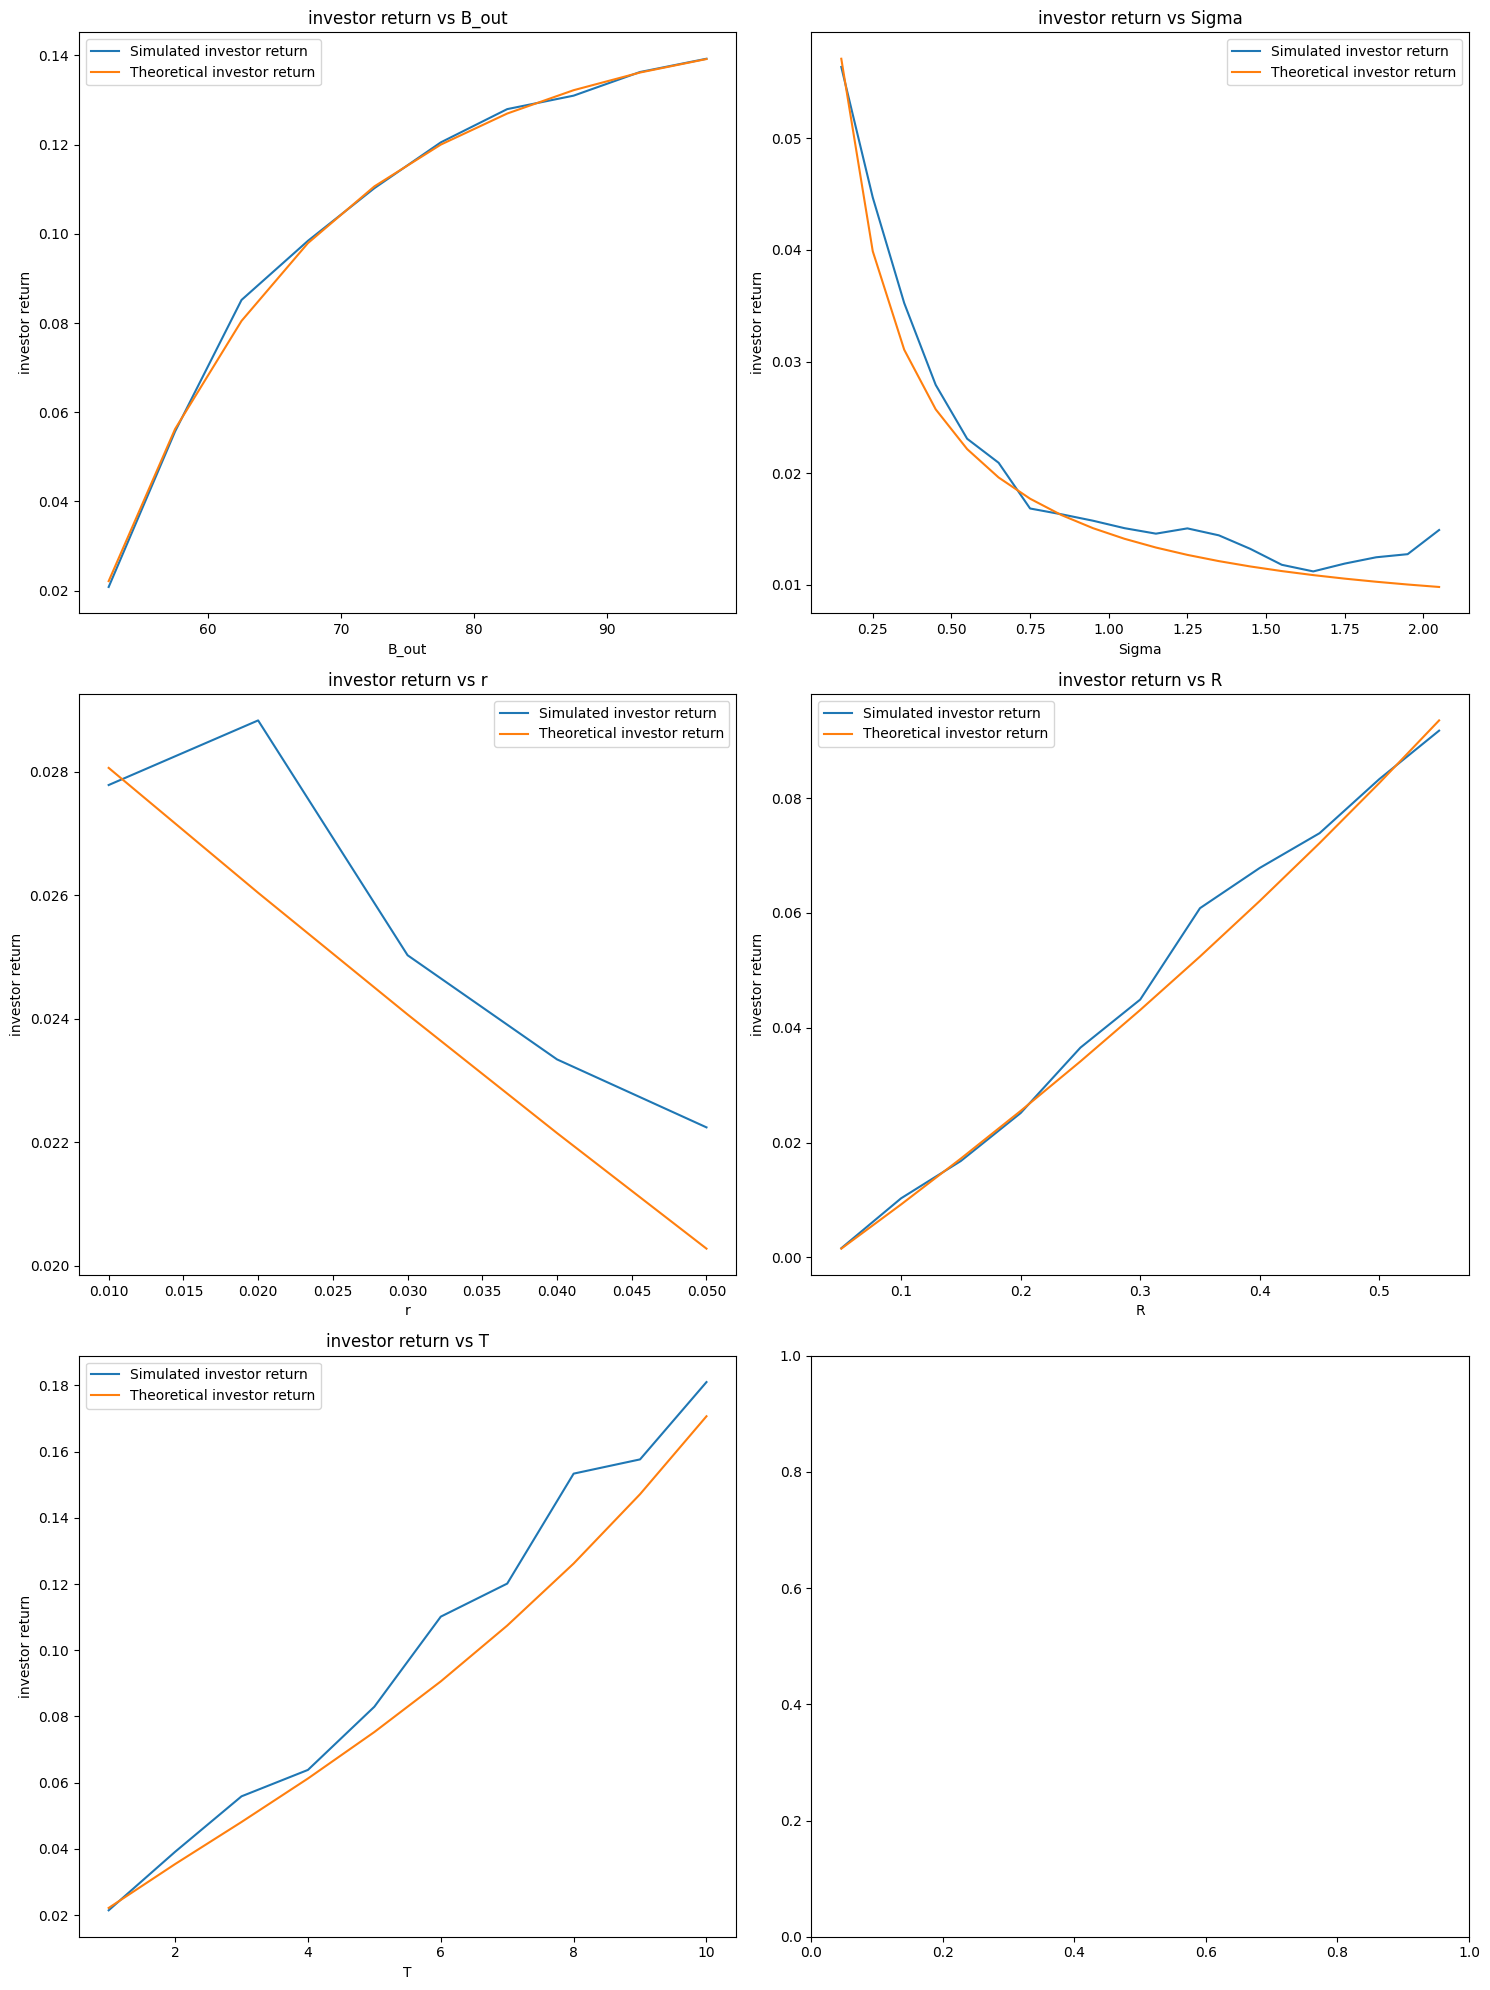

In [4]:
# Sweep parameters and plot results
def sweep_and_plot():
    S_0 = 50
    B_in = 0
    R = 0.18
    T = 1
    N_simulations = 1000
    M = 10000

    # Parameter ranges
    B_out_range = np.arange(1.05 * S_0, 2 * S_0, 0.1 * S_0)
    sigma_range = np.arange(0.15, 2.1, 0.1)
    r_range = np.arange(0.01, 0.06, 0.01)
    R_range = np.arange(0.05, 0.6, 0.05)
    T_range = np.arange(1, 11, 1)

    # Storage for mean premiums and theoretical values
    premiums_B_out = []
    theo_B_out = []
    premiums_sigma = []
    theo_sigma = []
    premiums_r = []
    theo_r = []
    premiums_R = []
    theo_R = []
    premiums_T = []
    theo_T = []

    for B_out in B_out_range:
        premium = simulated_premium(B_in, B_out, M, S_0, 0.55, 0.18, r = 0.04, T = 1, N_simulations = 1000)
        premiums_B_out.append(premium)
        theo_B_out.append(theoretical_value(S_0, 0.55, 0.04, 1, B_out, 0.18))

    for sigma in sigma_range:
        premium = simulated_premium(B_in, 1.05 * S_0, M, S_0, sigma, 0.18, r = 0.04, T = 1, N_simulations = 1000)
        premiums_sigma.append(premium)
        theo_sigma.append(theoretical_value(S_0, sigma, 0.04, 1, 1.05 * S_0, 0.18))

    for r in r_range:
        premium = simulated_premium(B_in, 1.05 * S_0, M, S_0, 0.55, 0.18, r, T = 1, N_simulations = 1000)
        premiums_r.append(premium)
        theo_r.append(theoretical_value(S_0, 0.55, r, 1, 1.05 * S_0, 0.18))

    for R_val in R_range:
        premium = simulated_premium(B_in, 1.05 * S_0, M, S_0, 0.55, R_val, 0.04, T = 1, N_simulations = 1000)
        premiums_R.append(premium)
        theo_R.append(theoretical_value(S_0, 0.55, 0.04, 1, 1.05 * S_0, R_val))

    for T_val in T_range:
        premium = simulated_premium(B_in, 1.05 * S_0, M, S_0, 0.55, R, 0.04, T_val, N_simulations = 1000)
        premiums_T.append(premium)
        theo_T.append(theoretical_value(S_0, 0.55, 0.04, T_val, 1.05 * S_0, 0.18))

    # Plotting
    fig, axs = plt.subplots(3, 2, figsize=(15, 20))

    axs[0, 0].plot(B_out_range, premiums_B_out, label='Simulated investor return')
    axs[0, 0].plot(B_out_range, theo_B_out, label='Theoretical investor return')
    axs[0, 0].set_title('investor return vs B_out')
    axs[0, 0].set_xlabel('B_out')
    axs[0, 0].set_ylabel('investor return')
    axs[0, 0].legend()

    axs[0, 1].plot(sigma_range, premiums_sigma, label='Simulated investor return')
    axs[0, 1].plot(sigma_range, theo_sigma, label='Theoretical investor return')
    axs[0, 1].set_title('investor return vs Sigma')
    axs[0, 1].set_xlabel('Sigma')
    axs[0, 1].set_ylabel('investor return')
    axs[0, 1].legend()

    axs[1, 0].plot(r_range, premiums_r, label='Simulated investor return')
    axs[1, 0].plot(r_range, theo_r, label='Theoretical investor return')
    axs[1, 0].set_title('investor return vs r')
    axs[1, 0].set_xlabel('r')
    axs[1, 0].set_ylabel('investor return')
    axs[1, 0].legend()

    axs[1, 1].plot(R_range, premiums_R, label='Simulated investor return')
    axs[1, 1].plot(R_range, theo_R, label='Theoretical investor return')
    axs[1, 1].set_title('investor return vs R')
    axs[1, 1].set_xlabel('R')
    axs[1, 1].set_ylabel('investor return')
    axs[1, 1].legend()

    axs[2, 0].plot(T_range, premiums_T, label='Simulated investor return')
    axs[2, 0].plot(T_range, theo_T, label='Theoretical investor return')
    axs[2, 0].set_title('investor return vs T')
    axs[2, 0].set_xlabel('T')
    axs[2, 0].set_ylabel('investor return')
    axs[2, 0].legend()

    plt.tight_layout()
    plt.show()

# Run the parameter sweep and plot function
sweep_and_plot()